In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 68.4MB/s]


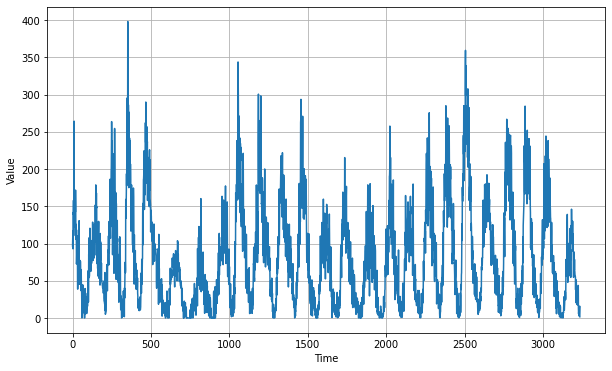

In [6]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

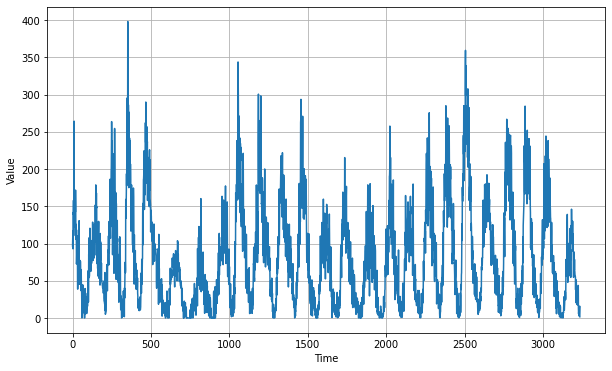

In [7]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 19s 84ms/step - loss: 79.8340 - mae: 80.3314 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 1s 56ms/step - loss: 78.0944 - mae: 78.5918 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 59ms/step - loss: 75.4519 - mae: 75.9497 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 59ms/step - loss: 72.2679 - mae: 72.7658 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 61ms/step - loss: 68.7693 - mae: 69.2672 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 60ms/step - loss: 65.1128 - mae: 65.6099 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 1s 64ms/step - loss: 61.5272 - mae: 62.0241 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 1s 60ms/step - loss: 58.1406 - mae: 58.6369 - 

(1e-08, 0.0001, 0.0, 60.0)

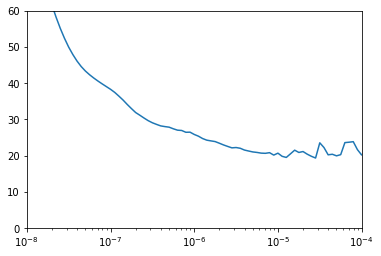

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 5s 40ms/step - loss: 38.9172 - mae: 39.4135
Epoch 2/500
30/30 [==============================] - 1s 37ms/step - loss: 25.7619 - mae: 26.2564
Epoch 3/500
30/30 [==============================] - 1s 38ms/step - loss: 22.0795 - mae: 22.5732
Epoch 4/500
30/30 [==============================] - 1s 38ms/step - loss: 20.4761 - mae: 20.9690
Epoch 5/500
30/30 [==============================] - 1s 38ms/step - loss: 19.7318 - mae: 20.2244
Epoch 6/500
30/30 [==============================] - 1s 39ms/step - loss: 19.3060 - mae: 19.7981
Epoch 7/500
30/30 [==============================] - 1s 39ms/step - loss: 18.6921 - mae: 19.1843
Epoch 8/500
30/30 [==============================] - 1s 39ms/step - loss: 18.2107 - mae: 18.7023
Epoch 9/500
30/30 [==============================] - 1s 39ms/step - loss: 18.0432 - mae: 18.5346
Epoch 10/500
30/30 [==============================] - 1s 39ms/step - loss: 19.5134 - mae: 20.0054
Epoch 11/500
30/30 [=========

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

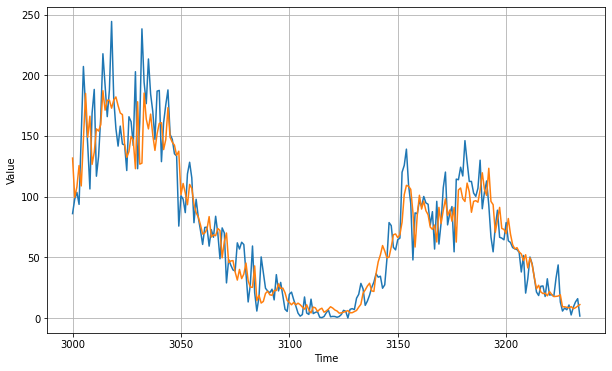

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.695176

<Figure size 432x288 with 0 Axes>

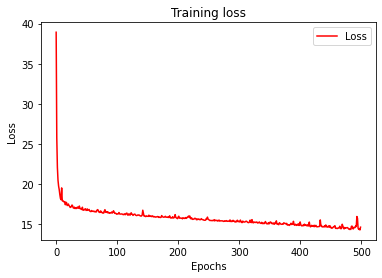

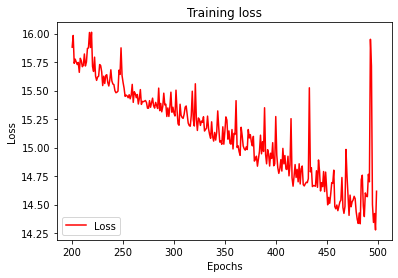

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [18]:
print(rnn_forecast)

[131.73724    99.37382   108.019844  125.57551   108.791115  145.98428
 185.00584   148.84576   166.25072   126.5334    136.38268   155.78268
 153.96417   159.25815   187.27278   171.24113   179.35669   179.40363
 172.85286   179.52603   182.12082   174.96764   168.86954   167.55603
 143.08948   132.3841    137.05658   149.59111   146.38118   122.99626
 178.13611   126.72752   127.551506  185.30554   163.781     155.78825
 167.96649   150.69623   138.07942   151.86018   160.29631   160.86113
 138.73582   147.01584   173.2654    148.82358   144.78458   142.40462
 133.99579   137.39082   101.52414   110.810486  103.02105    93.309875
 110.04262   106.77028    93.83797    86.727974   83.17994    76.69698
  69.162      70.04541    73.171906   83.51425    66.69383    68.53882
  67.77798    73.71955    72.074234   49.558224   62.821186   70.00659
  45.625504   46.98547    47.281284   37.88482    31.22604    39.984737
  32.441216   36.15737    45.23561    30.589924   25.39799    25.287945
  4